C:\Users\Arbaz Khan\AppData\Local\Temp\ipykernel_23648\1978227379.py:13: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)


Explained Variance Ratio by PCA: [0.59405772 0.14105705 0.1233786 ]
Labeled file saved as: D:\Master_Folder\Data Science Course\Projects\StockMarket\stock_data\SUZLON.NS_2024-01-01_to_2024-11-21_labeled.csv


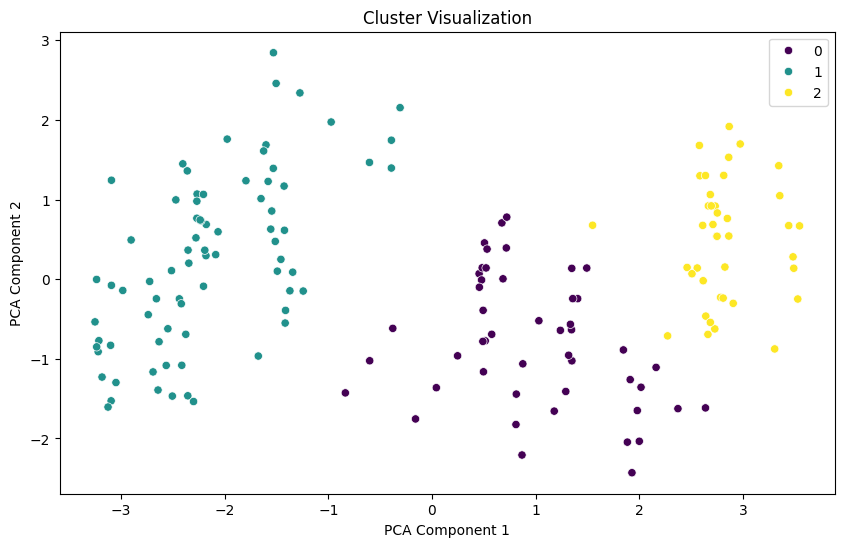

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

def unsupervised_buy_sell_hold(file_path):
    # Step 1: Load Data
    data = pd.read_csv(file_path)

    data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
    data.set_index('Date', inplace=True)
    data.sort_index(inplace=True)

    data['Day'] = data.index.day
    data['Weekday'] = data.index.weekday # 0 Monday, 6 Sunday
    data['Month'] = data.index.month
    data['Year'] = data.index.year

    # Generate lag feature for close price
    for lag in range(1, 4):
        data[f'Adj_Close_Lag_{lag}'] = data['Adj Close'].shift(lag)
    
    # Drop rows with NaN values created due to lagging
    data.dropna(inplace=True)
    
    # Select Feature Set 3
    features = ['Adj Close', 'Day', 'Weekday', 'Month', 'Year',
                'Adj_Close_Lag_1', 'Adj_Close_Lag_2', 'Adj_Close_Lag_3',
                'Upward_Downward_Probability']
    feature_data = data[features]

    # Step 2: Preprocessing
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(feature_data)

    # Dimensionality Reduction (Optional but Recommended)
    pca = PCA(n_components=3)  # Reduce to 3 dimensions for better clustering
    reduced_data = pca.fit_transform(scaled_data)
    print(f"Explained Variance Ratio by PCA: {pca.explained_variance_ratio_}")

    # Step 3: Apply Clustering Model
    kmeans = KMeans(n_clusters=3, random_state=42)
    data['Cluster'] = kmeans.fit_predict(reduced_data)

    # Step 4: Interpret Clusters
    # Assign cluster labels to Buy, Sell, Hold
    cluster_mapping = interpret_clusters(data, kmeans)
    data['Buy_Sell_Hold'] = data['Cluster'].map(cluster_mapping)

    # Step 5: Save Results
    data.to_csv(file_path.replace(".csv", "_labeled.csv"), index=False)
    print(f"Labeled file saved as: {file_path.replace('.csv', '_labeled.csv')}")

    # Step 6: Visualization (Optional)
    visualize_clusters(reduced_data, kmeans.labels_)

def interpret_clusters(data, kmeans):
    # Analyze cluster properties and assign labels
    cluster_mapping = {}
    cluster_means = data.groupby('Cluster')['Upward_Downward_Probability'].mean()

    for cluster in cluster_means.index:
        if cluster_means[cluster] > 0:
            cluster_mapping[cluster] = 'Buy'
        elif cluster_means[cluster] < -0.5:  # Adjust threshold as needed
            cluster_mapping[cluster] = 'Sell'
        else:
            cluster_mapping[cluster] = 'Hold'
    return cluster_mapping

def visualize_clusters(reduced_data, labels):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=labels, palette='viridis')
    plt.title('Cluster Visualization')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

# Main Execution
if __name__ == "__main__":
    unsupervised_buy_sell_hold('D:\Master_Folder\Data Science Course\Projects\StockMarket\stock_data\SUZLON.NS_2024-01-01_to_2024-11-21.csv')
